In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import pairwise_distances_argmin_min
plt.style.use('seaborn-colorblind')
%matplotlib inline

# Clustering by Fundamentals

In [36]:
# function for finding outliers
def is_outlier(col):
    mean = col.mean()
    sd = col.std()
    outliers = np.abs(col - mean) > sd*3 
    return outliers

# Scatter plot function for mulit class data 
def multi_class_scatter_plot(arr_1, arr_2, y, size, title):
    import matplotlib.colors as colors
    color_list = list(colors.cnames.keys())
    classes = np.unique(y)

    fig, ax = plt.subplots(figsize=size)
    for i in classes:
        color = np.random.choice(color_list)
        mask = y == i
        ax.scatter(arr_1[mask], arr_2[mask], c=color, label=f"{i}")

    ax.legend()
    plt.title(title)
    
# Plot silhouette scores to determine optimal number of n_clusters
def plot_silhouette(max_clusters, X):
    sil_scores = []
    x_values = []
    for i in range(2,max_clusters+1):
        x_values.append(i)
        clf = KMeans(n_clusters=i, max_iter=100, init='k-means++', n_init=10)
        labels = clf.fit_predict(X)
        sil_scores.append(silhouette_score(X, labels))
    fig, ax = plt.subplots(1,1, figsize=(5,5)) 
    ax.plot(x_values, sil_scores)
    plt.title('Silhouette Score')
    plt.xlabel('n_clusters')
    plt.ylabel('silhouette_score')

def K_means_clusters(X, n_clusters):    
    n_clusters = n_clusters
    clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
    labels = clf.fit_predict(X)
    cluster_labels = labels.reshape(X.shape[0],1)
    X_embedded = np.append(X, cluster_labels, axis=1)
    return X_embedded, clf

In [5]:
X = pd.read_pickle('data/stocks_ratios_labels.pkl')

In [6]:
X_final_ratios = X.iloc[:,0:8].iloc[:,2:]
outlier_list = X_final_ratios.apply(lambda x: is_outlier(x)).apply(lambda row: np.any(row), axis=1)
X_no_outliers = X_final_ratios[~outlier_list]

In [7]:
X_no_outliers.head()

,Net Profit Margin,Return on Equity,Return on Assets,Current Ratio,Liabilities to Equity Ratio,Debt to Assets Ratio
FLWS,0.0393,0.1753,0.0909,2.1515,0.9275,0.2096
FOX,0.1124,0.1856,0.0626,2.0790,1.9635,0.3815
DDD,-0.0788,-0.0803,-0.0595,2.6310,0.3494,0.0093
EGHT,-0.3320,-0.4272,-0.3425,3.5451,0.2473,0.0000
AMRK,0.0004,0.0379,0.0053,1.0937,6.2186,0.4190


## Clustering Anlysis (unscaled)

In [37]:
X_embedded = TSNE(n_components=2).fit_transform(X_no_outliers.iloc[:, 0:6])

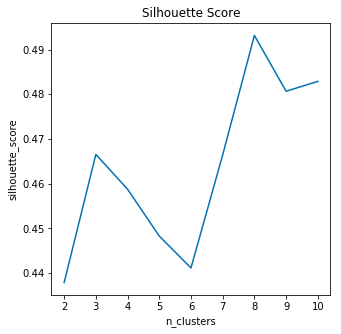

In [38]:
plot_silhouette(10, X_embedded)

In [39]:
X_embedded, clf = K_means_clusters(X_embedded, 8)

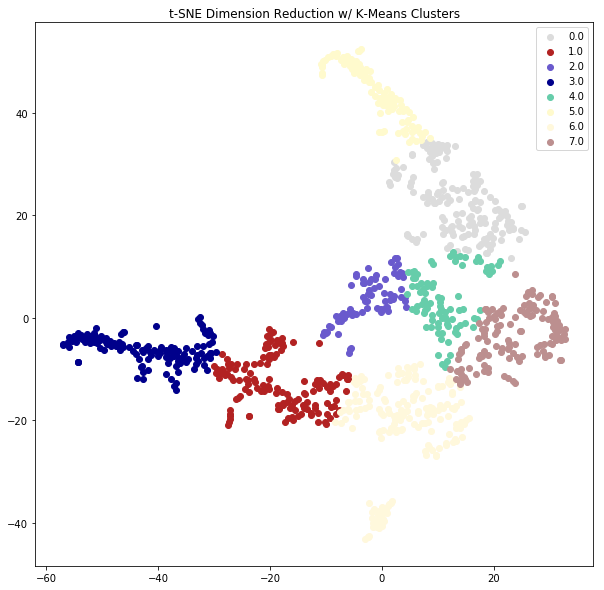

In [40]:
multi_class_scatter_plot(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], (10,10), 't-SNE Dimension Reduction w/ K-Means Clusters')

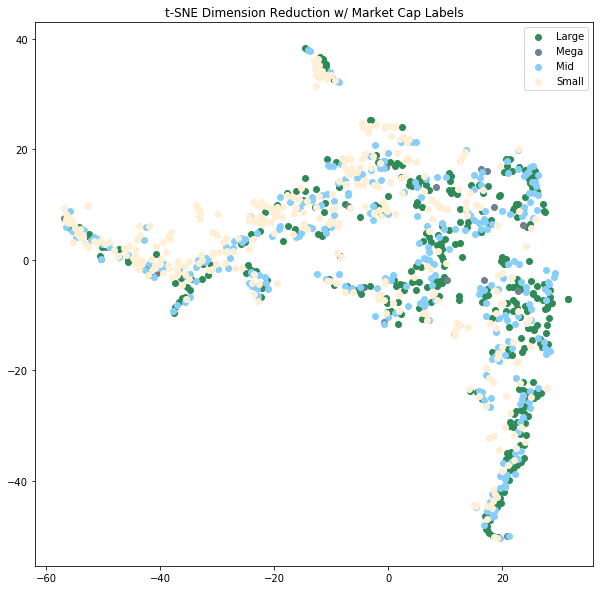

In [22]:
multi_class_scatter_plot(X_embedded[:, 0], X_embedded[:, 1], X[~outlier_list]['Market Cap'], (10,10), 't-SNE Dimension Reduction w/ Market Cap Labels')

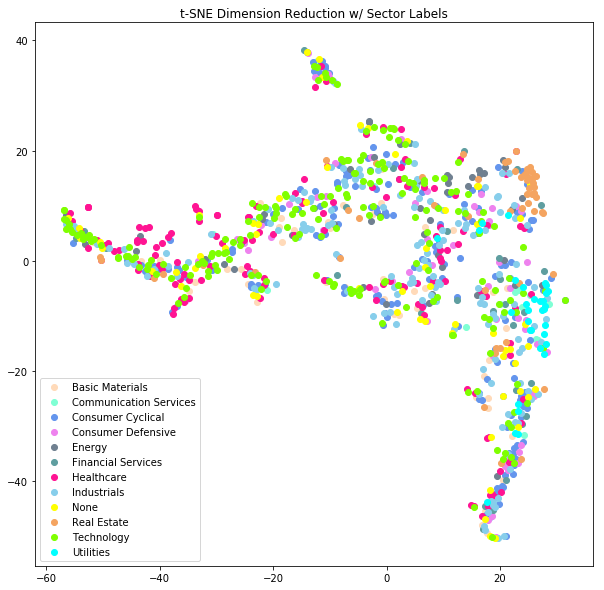

In [23]:
multi_class_scatter_plot(X_embedded[:, 0], X_embedded[:, 1], X[~outlier_list]['Sector'].fillna('None'), (10,10), 't-SNE Dimension Reduction w/ Sector Labels')

In [24]:
clf.cluster_centers_

NameError: name 'clf' is not defined

## Centroid Stocks

In [76]:
closest, _ = pairwise_distances_argmin_min(clf.cluster_centers_, X_embedded[:,0:2])

In [77]:
closest

array([724, 716, 499, 514, 595, 596, 386, 221])

In [82]:
X_no_outliers.iloc[closest].index

Index(['PRLB', 'PII', 'SJM', 'K', 'MLAB', 'MEI', 'FTEK', 'CTAS'], dtype='object')

In [25]:
def cluster_analysis(X, X_nl, labels, n_clusters):
    cluster_sectors = []
    cluster_caps = []
    cluster_stats = []
    for i in range(n_clusters):
        mask = labels == i
        stats = X_nl.loc[mask].describe().loc['mean']
        cluster_stats.append(stats)
        sectors = X[~outlier_list][mask]['Sector'].value_counts()
        cluster_sectors.append(sectors)
        caps = X[~outlier_list][mask]['Market Cap'].value_counts()
        cluster_caps.append(caps)
    return cluster_stats, cluster_sectors, cluster_caps

In [26]:
def make_stats_list(init_list, index, n_clusters):
    for i in range(n_clusters):
        init_list.append(stats[i][index])
    return init_list

In [28]:
stats, sectors, caps = cluster_analysis(X, X_no_outliers, X_embedded[:,2], 8)

In [30]:
net_profit_margins = []
net_profit_margins = make_stats_list(net_profit_margins, 0, 8)
return_on_equity = []
return_on_equity = make_stats_list(return_on_equity, 1, 8)
return_on_assets = []
return_on_assets = make_stats_list(return_on_assets, 2, 8)
current_ratio = []
current_ratio = make_stats_list(current_ratio, 3, 8)
liabilities_to_equity = []
liabilities_to_equity = make_stats_list(liabilities_to_equity, 4, 8)
debt_to_assets = []
debt_to_assets = make_stats_list(debt_to_assets, 5, 8)
stats_list = [net_profit_margins, return_on_equity, return_on_assets, current_ratio, liabilities_to_equity, debt_to_assets]

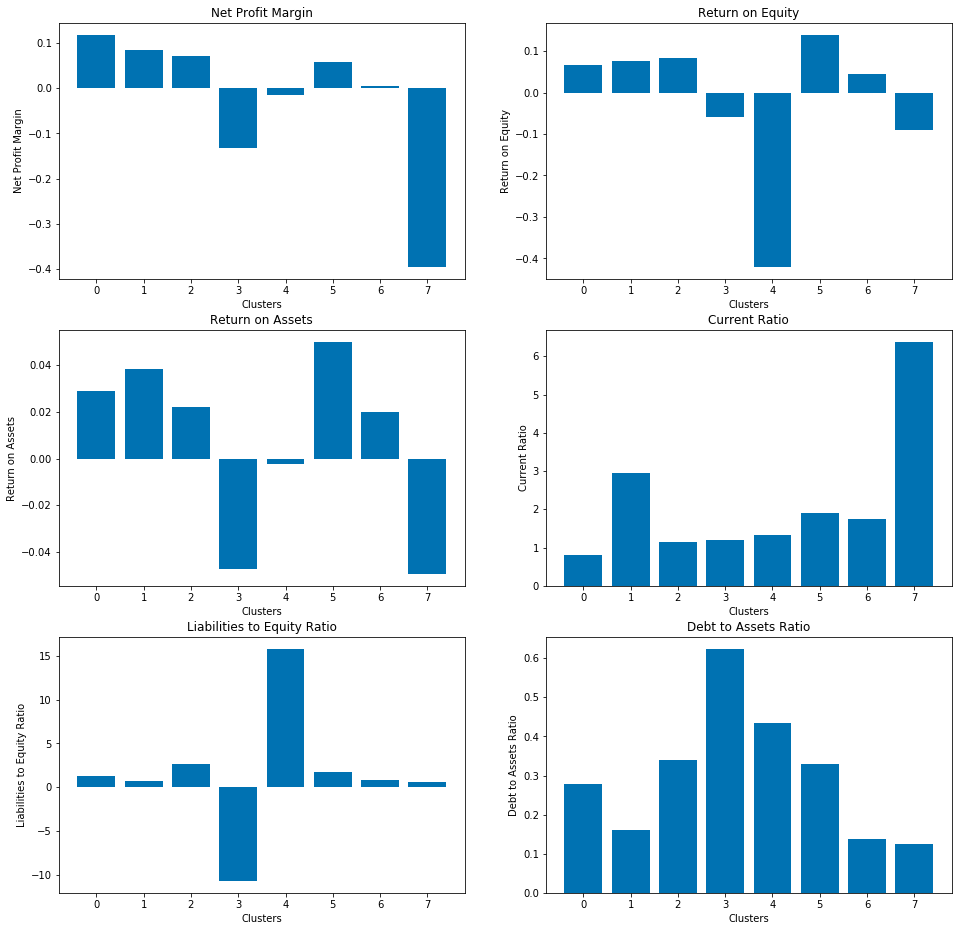

In [31]:
fig, axes = plt.subplots(3,2, figsize=(16,16))
axes = axes.flatten()
for idx, ax in enumerate(axes): 
    ax.bar(np.arange(len(stats_list[idx])), stats_list[idx])
    ax.set_xlabel('Clusters')
    ax.set_ylabel(stats[0].index[idx])
    ax.set_title(stats[0].index[idx])

## Clustering Analysis (scaled)

In [94]:
def scaler(X): 
    scaler = StandardScaler()
    X_transform = scaler.fit_transform(X)
    return X_transform

In [105]:
X_scaled_embedded = scaler(X_no_outliers.iloc[:, 0:6])
X_scaled_embedded = TSNE(n_components=2).fit_transform(X_scaled_embedded)

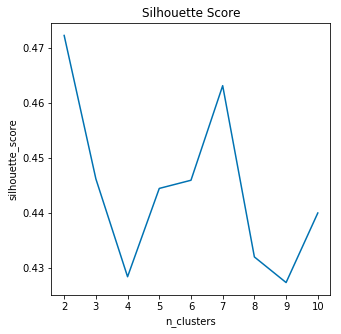

In [106]:
plot_silhouette(10, X_scaled_embedded)

In [107]:
n_clusters = 7
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X_scaled_embedded)
cluster_labels = labels.reshape(986,1)
X_scaled_embedded = np.append(X_scaled_embedded, cluster_labels, axis=1)

In [113]:
stats, sectors, caps = cluster_analysis(X, X_no_outliers, X_scaled_embedded[:,2], 7)

In [117]:
net_profit_margins = []
net_profit_margins = make_stats_list(net_profit_margins, 0, 7)
return_on_equity = []
return_on_equity = make_stats_list(return_on_equity, 1, 7)
return_on_assets = []
return_on_assets = make_stats_list(return_on_assets, 2, 7)
current_ratio = []
current_ratio = make_stats_list(current_ratio, 3, 7)
liabilities_to_equity = []
liabilities_to_equity = make_stats_list(liabilities_to_equity, 4, 7)
debt_to_assets = []
debt_to_assets = make_stats_list(debt_to_assets, 5, 7)
stats_list = [net_profit_margins, return_on_equity, return_on_assets, current_ratio, liabilities_to_equity, debt_to_assets]

In [132]:
def make_stats_plots(stats_list, stats):
    fig, axes = plt.subplots(3,2, figsize=(16,16))
    axes = axes.flatten()
    for idx, ax in enumerate(axes): 
        ax.bar(np.arange(len(stats_list[idx])), stats_list[idx])
        ax.set_xlabel('Clusters')
        ax.set_ylabel(stats[0].index[idx])
        ax.set_title(stats[0].index[idx])

### Average Stats (per cluster)

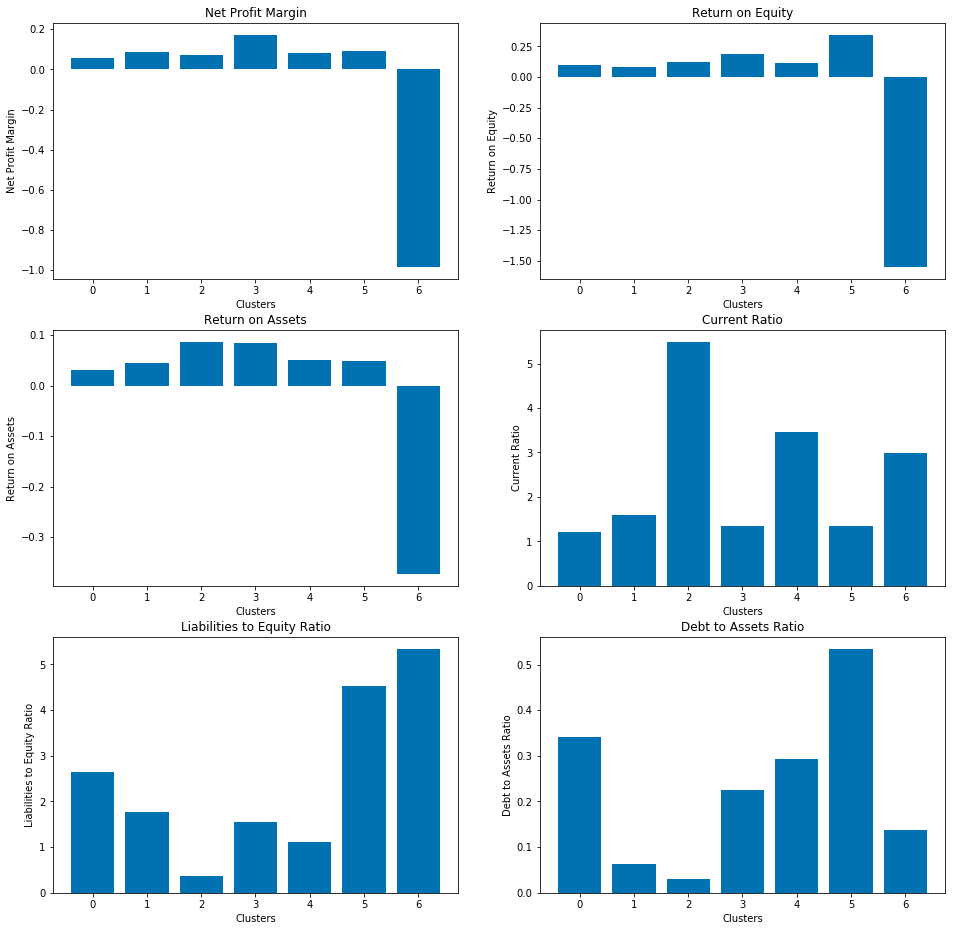

In [133]:
make_stats_plots(stats_list, stats)

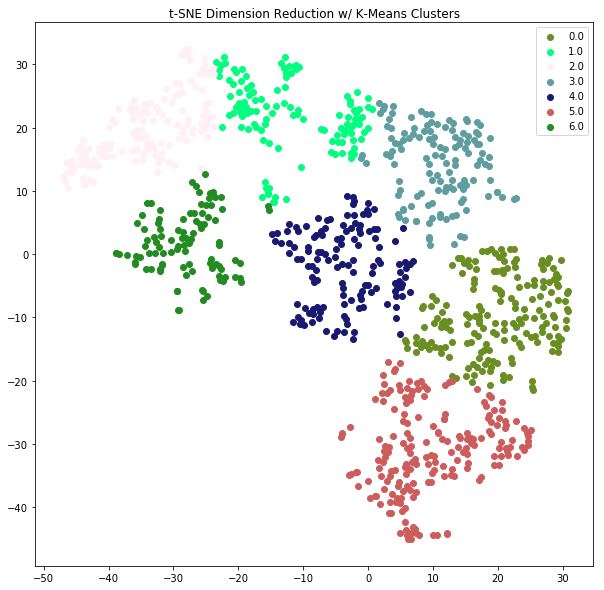

In [138]:
multi_class_scatter_plot(X_scaled_embedded[:, 0], X_scaled_embedded[:, 1], X_scaled_embedded[:, 2], (10,10), 't-SNE Dimension Reduction w/ K-Means Clusters')

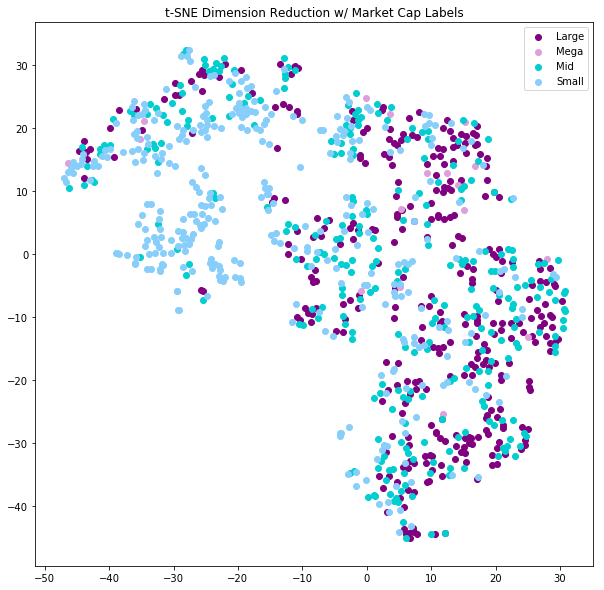

In [142]:
multi_class_scatter_plot(X_scaled_embedded[:, 0], X_scaled_embedded[:, 1], X[~outlier_list]['Market Cap'], (10,10), 't-SNE Dimension Reduction w/ Market Cap Labels')

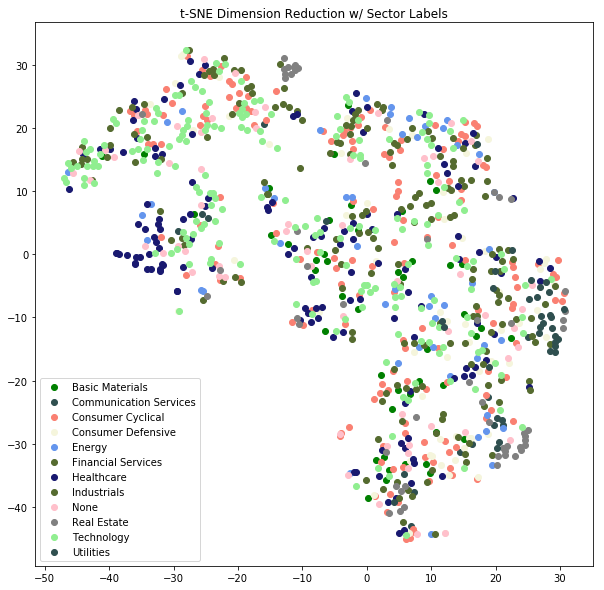

In [158]:
multi_class_scatter_plot(X_scaled_embedded[:, 0], X_scaled_embedded[:, 1], X[~outlier_list]['Sector'].fillna('None'), (10,10), 't-SNE Dimension Reduction w/ Sector Labels')

In [134]:
closest, _ = pairwise_distances_argmin_min(clf.cluster_centers_, X_scaled_embedded[:,0:2])

In [135]:
X_no_outliers.iloc[closest].index

Index(['TWX', 'CSU', 'MRVL', 'DHR', 'LFUS', 'PEP', 'CPST'], dtype='object')